In [2]:
# https://medium.com/ensina-ai/machine-learning-randomforest-para-prever-nota-de-matem%C3%A1tica-do-enem-2016-8893b73882f4
# Dicas muito boas

# Importar as bibliotecas a serem usadas
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Leitura dos datasets de treino e teste e criação do df de resposta
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_resposta = pd.DataFrame()

In [4]:
# Verificar se os dados de teste estão nos dados de treinamento
print(set(df_test.columns).issubset(set(df_train.columns)))

True


In [5]:
# Salvar os dados das inscrições
df_resposta['NU_INSCRICAO'] = df_test['NU_INSCRICAO']

In [6]:
# Selecionar somente valores inteiros e floats
df_test = df_test.select_dtypes(include=['int64','float64'])

In [7]:
var = ['NU_IDADE','IN_TREINEIRO','NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO']
df_test[var].corr()

,NU_IDADE,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO
NU_IDADE,1.000000,-0.293714,-0.105278,-0.048229,-0.079171,-0.161202
IN_TREINEIRO,-0.293714,1.000000,-0.009669,-0.032181,-0.004934,-0.014277
NU_NOTA_CN,-0.105278,-0.009669,1.000000,0.598574,0.545801,0.442692
NU_NOTA_CH,-0.048229,-0.032181,0.598574,1.000000,0.679993,0.537141
NU_NOTA_LC,-0.079171,-0.004934,0.545801,0.679993,1.000000,0.495745
NU_NOTA_REDACAO,-0.161202,-0.014277,0.442692,0.537141,0.495745,1.000000


In [8]:
# Após a verificação da correlação dos dados, foram selecionadas para a criação do modelo preditivo somente as
# features NU_NOTA_CN (nota da prova de Ciências Naturais), NU_NOTA_CH (nota da prova de Ciências Humanas), 
# NU_NOTA_LC (nota da prova de Linguagens e Códigos) e a NU_NOTA_REDACAO (nota final da redação).

features = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO']

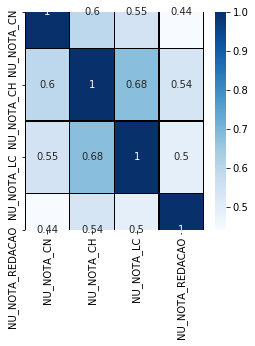

In [15]:
%matplotlib inline

plt.figure(figsize=(4,4))
sns.heatmap(df_test[features].corr(), annot=True, linewidths=0.5, linecolor='black', cmap='Blues')
plt.xticks(rotation=90)
plt.show()

In [16]:
# Usando o loc com uma condição composta para obter somente registros com todas as provas
df_train = df_train.loc[(df_train['NU_NOTA_CN'].notnull()) & (df_train['NU_NOTA_CH'].notnull())  & (df_train['NU_NOTA_LC'].notnull()) & (df_train['NU_NOTA_REDACAO'].notnull()) & (df_train['NU_NOTA_MT'].notnull())]

In [17]:
df_test[features].isnull().sum()

NU_NOTA_CN         1134
NU_NOTA_CH         1134
NU_NOTA_LC         1199
NU_NOTA_REDACAO    1199
dtype: int64

In [18]:
#Esse problema pode ser solucionado através das seguintes opções:

#Exclusão das notas: O que não é uma solução viável, pois irá excluir registros de pessoas que fizeram todas as provas, mas pode ter corrompido uma de suas notas durante a extração dos dados, por exemplo;
#Preenchimento com zeros: Após a realização de testes em modelos de regressão anteriores, essa opção não gerou bons resultados, reduzindo drasticamente o valor final das notas estimadas;
#Preenchimento das notas faltantes com a média da coluna das notas encontradas: Será a opção mais viável no momento, utilizada nesse estudo.

#Preenchimento dos valores nulos das notas com a média dos valores das provas:

In [19]:
# Preencher valores nulos com o valor médio - Tratamento das notas de provas corrompidas
df_train['NU_NOTA_CN'].fillna(df_train['NU_NOTA_CN'].mean(), inplace=True)
df_train['NU_NOTA_CH'].fillna(df_train['NU_NOTA_CH'].mean(), inplace=True)
df_train['NU_NOTA_REDACAO'].fillna(df_train['NU_NOTA_REDACAO'].mean(), inplace=True)
df_train['NU_NOTA_LC'].fillna(df_train['NU_NOTA_LC'].mean(), inplace=True)
df_test['NU_NOTA_CN'].fillna(df_train['NU_NOTA_CN'].mean(), inplace=True)
df_test['NU_NOTA_CH'].fillna(df_train['NU_NOTA_CH'].mean(), inplace=True)
df_test['NU_NOTA_REDACAO'].fillna(df_train['NU_NOTA_REDACAO'].mean(), inplace=True)
df_test['NU_NOTA_LC'].fillna(df_train['NU_NOTA_LC'].mean(), inplace=True)

In [20]:
y = df_train['NU_NOTA_MT']

In [21]:
# Definição do dataset de treino somente com as informações relevantes para treinar o modelo
features = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO']
x_train = df_train[features]

In [22]:
# Ajustando o Transformer API
scaler = preprocessing.StandardScaler().fit(x_train)

In [23]:
X_train_scaled = scaler.transform(x_train)
print('Média: {}'.format(X_train_scaled.mean(axis=1)))
print('Desvio Padrão: {}'.format(X_train_scaled.std(axis=0)))

Média: [-0.03069405  0.43165148 -0.17994011 ...  0.25471651  0.20825568
  0.3693551 ]
Desvio Padrão: [1. 1. 1. 1.]


In [24]:
x_test = df_test[features]

In [25]:
#n_estimators=100 (número de nós) , n_jobs=-1 ( todo o processamento possível) , warm_start=True (mantém o aprendizado e reprocessa o modelo, melhorando-o)
pipeline = make_pipeline(preprocessing.StandardScaler(), RandomForestRegressor(n_estimators=200, n_jobs=-1, warm_start=True))

In [31]:
# max_features : O número de features a considerar quando pesquisar pela melhor separação 
#                (testará as 3 opções e identificará a melhor para o modelo)
# max_depth :  Profundidade máxima da árvore de decisão. 
#              Se None (nenhuma), os nós serão expandidos até acabar as folhas ou até que elas contenham o
#              mínimo valor de amostras possível.
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                    'randomforestregressor__max_depth': [None, 7, 3, 1]}

In [32]:
# Ajustar e sintonizar o modelo
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
clf.fit(X_train_scaled, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split

In [33]:
print(clf.best_params_)

{'randomforestregressor__max_depth': 7, 'randomforestregressor__max_features': 'log2'}


In [34]:
pred_notas = clf.predict(x_test)

In [35]:
df_resposta['NU_NOTA_MT'] = np.around(pred_notas,2)

In [37]:
df_resposta['NU_NOTA_MT'].unique()

array([833.1 , 831.  , 495.85, 776.42, 770.04, 545.41])

In [38]:
#Gerando o arquivo de respostas com a inscrição do aluno e a nota de matemática predita:
df_resposta.to_csv('answer.csv', index=False, header=True)

In [39]:
df_resposta

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,833.1
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,833.1
2,b38a03232f43b11c9d0788abaf060f7366053b6d,833.1
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,833.1
4,715494628a50142ce8cb17191cfe6d0f3cae0934,833.1
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,833.1
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,833.1
4573,655fa6306720ff16e825903b5422a46608a77545,833.1
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,833.1


In [40]:
# Salvar o modelo preditivo
joblib.dump(clf, 'rf_regressor.pkl')

# Usar/carregar o modelo preditivo
clf2 = joblib.load('rf_regressor.pkl')
clf2.predict(x_test)

array([833.10237812, 833.10237812, 833.10237812, ..., 833.10237812,
       833.10237812, 833.10237812])